# 📊 Implementasi Deep Learning

**Judul:** Implementasi Convolutional Neural Network dengan Arsitektur VGG16 untuk Klasifikasi Penyakit Daun Tanaman Jeruk

- Dataset 1: Dataset Penyakit Daun Jeruk (asli)
- Dataset 2: Dataset Penyakit Daun Jeruk Modif (jumlah gambar seimbang)


In [ ]:
# ====================================
# LANGKAH 1: Mount dan Persiapkan Dataset
# ====================================
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

# Unzip Dataset Original
ori_zip_path = '/content/drive/MyDrive/Dataset Penyakit Daun Jeruk.zip'
ori_extract_path = '/content/dataset_ori'
os.makedirs(ori_extract_path, exist_ok=True)
with zipfile.ZipFile(ori_zip_path, 'r') as zip_ref:
    zip_ref.extractall(ori_extract_path)

# Unzip Dataset Modifikasi
mod_zip_path = '/content/drive/MyDrive/Dataset Penyakit Daun Jeruk Modif.zip'
mod_extract_path = '/content/dataset_mod'
os.makedirs(mod_extract_path, exist_ok=True)
with zipfile.ZipFile(mod_zip_path, 'r') as zip_ref:
    zip_ref.extractall(mod_extract_path)

Mounted at /content/drive


In [ ]:
# ====================================
# LANGKAH 2: Image Generator
# ====================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_ori = datagen.flow_from_directory(
    os.path.join(ori_extract_path, 'Citrus Leaf Disease Image'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

val_mod = datagen.flow_from_directory(
    os.path.join(mod_extract_path, 'Citrus Leaf Disease Image'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(val_ori.class_indices.keys())

Found 118 images belonging to 5 classes.
Found 170 images belonging to 5 classes.


In [ ]:
# ====================================
# LANGKAH 3: Load Model VGG16
# ====================================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

def build_model():
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(len(class_names), activation='softmax')
    ])
    return model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ====================================
# LANGKAH 4: Training Model (original & modif)
# ====================================
train_ori = datagen.flow_from_directory(
    os.path.join(ori_extract_path, 'Citrus Leaf Disease Image'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

train_mod = datagen.flow_from_directory(
    os.path.join(mod_extract_path, 'Citrus Leaf Disease Image'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Train model original
epochs = 25
model_ori = build_model()
model_ori.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_ori.fit(train_ori, validation_data=val_ori, epochs=epochs)

# Train model modifikasi
model_mod = build_model()
model_mod.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_mod.fit(train_mod, validation_data=val_mod, epochs=epochs)

Found 489 images belonging to 5 classes.
Found 680 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 375s 24s/step - accuracy: 0.2820 - loss: 1.4581 - val_accuracy: 0.5254 - val_loss: 1.3172
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 372s 24s/step - accuracy: 0.4323 - loss: 1.3096 - val_accuracy: 0.5085 - val_loss: 1.2426
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 393s 24s/step - accuracy: 0.4982 - loss: 1.2478 - val_accuracy: 0.5000 - val_loss: 1.1860
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 373s 24s/step - accuracy: 0.5031 - loss: 1.1740 - val_accuracy: 0.5339 - val_loss: 1.1196
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 375s 24s/step - accuracy: 0.5303 - loss: 1.1389 - val_accuracy: 0.5593 - val_loss: 1.0920
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 372s 24s/step - accuracy: 0.5597 - loss: 1.0310 - val_accuracy: 0.6441 - val_loss: 1.0450
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 374s 24s/step - accuracy: 0.5545 - loss: 1.0298 - val_accuracy: 0.5932 - val_loss: 1.0216
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 372s 24s/step - accuracy: 0.6287 - loss: 0.9467 - val_accuracy: 0.

In [ ]:
# ====================================
# LANGKAH 5: Prediksi dari Validation Generator
# ====================================
import numpy as np

# Fungsi untuk mengambil semua data dari generator
def extract_predictions(model, generator):
    generator.reset()
    all_images = []
    all_true_labels = []
    all_pred_labels = []

    for _ in range(len(generator)):
        imgs, labels = next(generator)
        preds = model.predict(imgs)
        all_images.extend(imgs)
        all_true_labels.extend(np.argmax(labels, axis=1))
        all_pred_labels.extend(np.argmax(preds, axis=1))

    return np.array(all_images), np.array(all_true_labels), np.array(all_pred_labels)

img_ori, true_ori, pred_ori = extract_predictions(model_ori, val_ori)
img_mod, true_mod, pred_mod = extract_predictions(model_mod, val_mod)

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step



=== Model - Dataset Original ===
              precision    recall  f1-score   support

  Black spot       0.64      0.42      0.51        33
      Canker       1.00      0.88      0.93        32
    Greening       0.54      0.85      0.66        40
     Healthy       0.67      0.18      0.29        11
    Melanose       1.00      1.00      1.00         2

    accuracy                           0.68       118
   macro avg       0.77      0.67      0.68       118
weighted avg       0.71      0.68      0.66       118



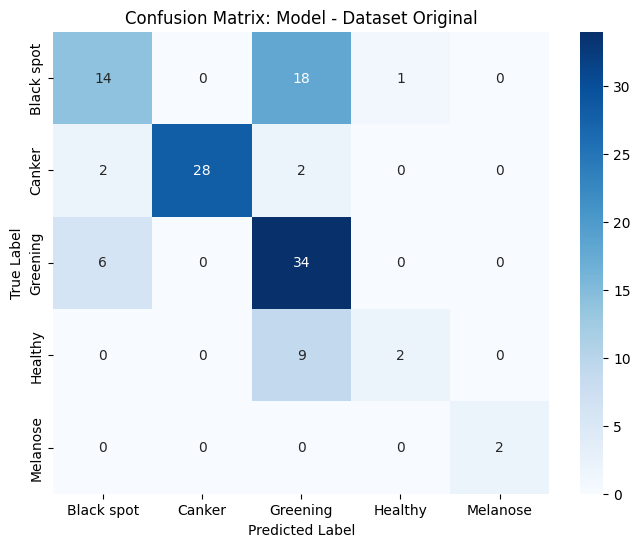


=== Model - Dataset Modifikasi ===
              precision    recall  f1-score   support

  Black spot       0.58      0.65      0.61        34
      Canker       0.88      0.82      0.85        34
    Greening       0.68      0.56      0.61        34
     Healthy       0.87      0.97      0.92        34
    Melanose       1.00      1.00      1.00        34

    accuracy                           0.80       170
   macro avg       0.80      0.80      0.80       170
weighted avg       0.80      0.80      0.80       170



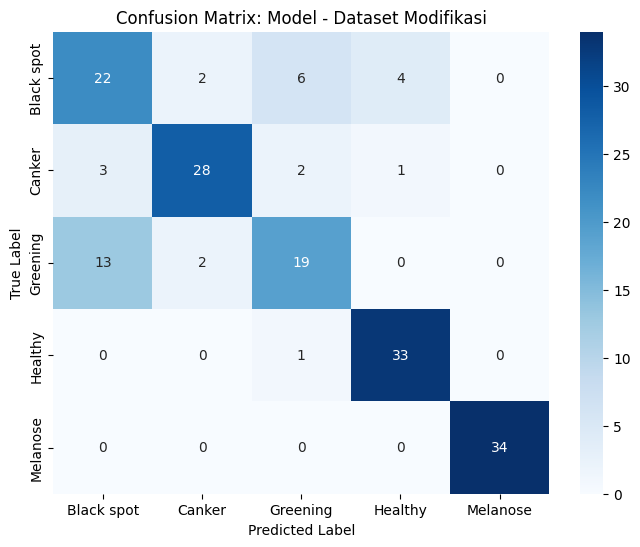

In [ ]:
# ====================================
# LANGKAH 6: Evaluasi Numerik (Confusion Matrix + Report)
# ====================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def print_evaluation_metrics(true_labels, pred_labels, label_names, title=""):
    print(f"\n=== {title} ===")
    print(classification_report(true_labels, pred_labels, target_names=label_names))

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Tampilkan evaluasi
print_evaluation_metrics(true_ori, pred_ori, class_names, title="Model - Dataset Original")
print_evaluation_metrics(true_mod, pred_mod, class_names, title="Model - Dataset Modifikasi")


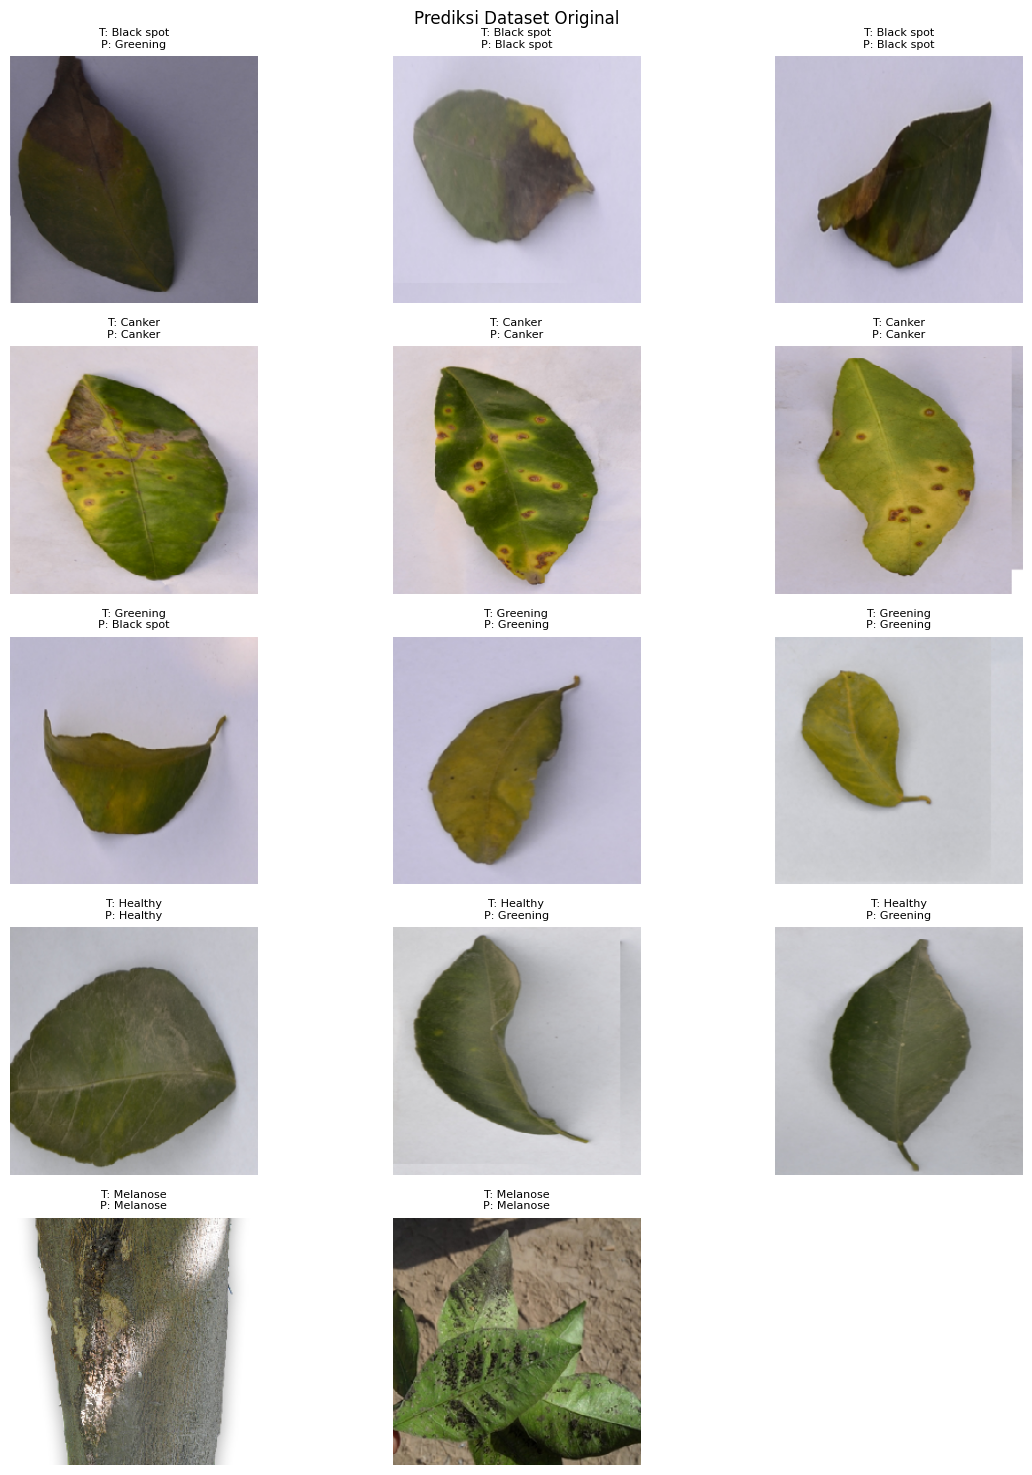

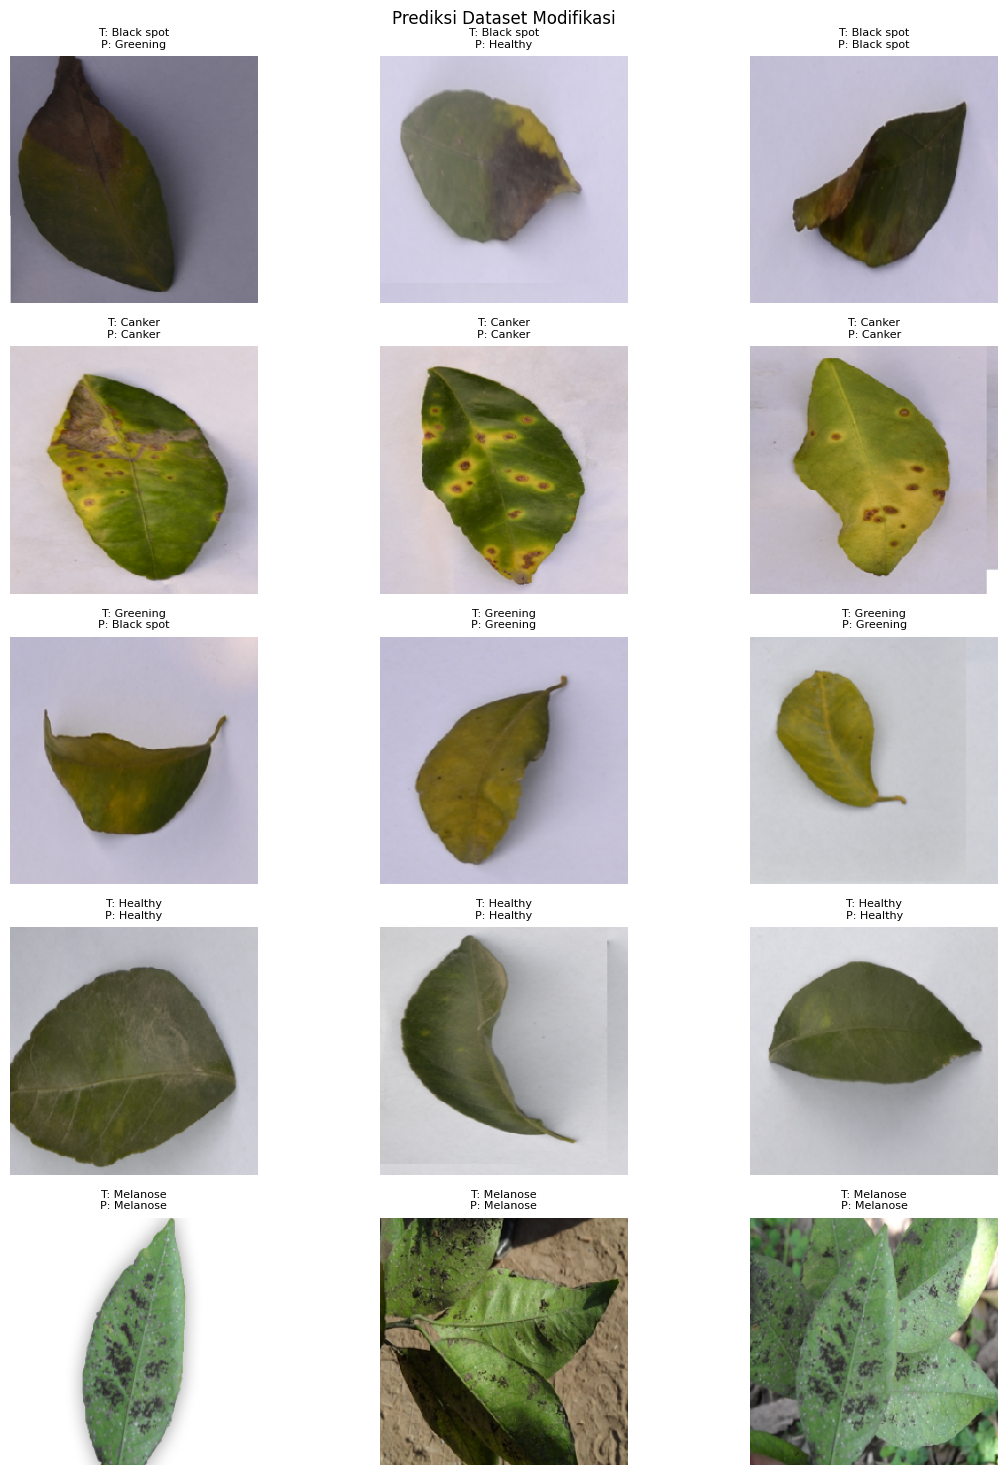

In [ ]:
# ====================================
# LANGKAH 7: Visualisasi Prediksi
# ====================================
import matplotlib.pyplot as plt

num_samples_per_class = 3

def plot_predictions(images, true_labels, pred_labels, class_names, title):
    plt.figure(figsize=(12, len(class_names) * 3))
    plot_idx = 1
    for class_idx, class_name in enumerate(class_names):
        indices = np.where(true_labels == class_idx)[0][:num_samples_per_class]
        for i in indices:
            plt.subplot(len(class_names), num_samples_per_class, plot_idx)
            plt.imshow(images[i])
            plt.axis('off')
            t_label = class_names[true_labels[i]]
            p_label = class_names[pred_labels[i]]
            plt.title(f"T: {t_label}\nP: {p_label}", fontsize=8)
            plot_idx += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_predictions(img_ori, true_ori, pred_ori, class_names, "Prediksi Dataset Original")
plot_predictions(img_mod, true_mod, pred_mod, class_names, "Prediksi Dataset Modifikasi")